# Phase 2: Fine-Tuning Pretrained Models on a Fine-Grained Cat Breed Dataset

## Introduction

This phase builds upon the work completed in **Phase 1**, where a dataset of 23 fine-grained cat breeds was organized, labeled, and explored. In Phase 1, key foundational tasks were completed:
- High-quality image data was collected and labeled per breed
- Data was analyzed to understand class distribution and visual diversity
- Pretrained CNN architectures (VGG16 and ResNet50) were tested in their frozen configurations to establish baseline accuracy

---

### Objective of Phase 2

The goal of this phase is to significantly improve model performance by fine-tuning pretrained CNNs using carefully controlled strategies.

This includes:
- Applying strong and diverse **data augmentation** to improve generalization
- Fine-tuning **VGG16** and **ResNet50** using various combinations of unfrozen layers and learning rate schedules
- **Comparing model performance** using validation and test metrics
- Conducting in-depth analysis of **misclassified images** to understand and explain model weaknesses

This phase is critical to transforming baseline models into robust breed classifiers capable of distinguishing subtle differences across visually similar classes.

---

### Initial Setup and Library Imports

The following code block loads all the core libraries required for training, evaluation, and visualization. It includes modules for:
- Neural network implementation (PyTorch, torchvision)
- Data transformation and loading
- Evaluation metrics (confusion matrices, classification reports)
- Data handling and visualization (Pandas, NumPy, Matplotlib, Seaborn, PIL)

These imports set up the working environment for all stages of fine-tuning and evaluation.

In [1]:
# Basic Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# PyTorch Libraries
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

# Sklearn for Evaluation
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import random

In [2]:
# Dataset Path
base_path = 'Images and labels/Data/Abhi'

# Load Labels
labels_df = pd.read_csv('Images and labels/abhi_labels.csv')

print("Total Images:", len(labels_df))
print("Total Breeds:", labels_df['Breed Name'].nunique())

labels_df.head()

Total Images: 456
Total Breeds: 23


,Image ID,Path,Breed Name,Coat Length,Personality
0,Abyssinian_35,Data/Abhi\Abyssinian\Abyssinian_35.jpg,Abyssinian,ShortHair,"Busy, active, agenda-driven and affectionate"
1,Abyssinian_36,Data/Abhi\Abyssinian\Abyssinian_36.jpg,Abyssinian,ShortHair,"Busy, active, agenda-driven and affectionate"
2,Abyssinian_37,Data/Abhi\Abyssinian\Abyssinian_37.jpg,Abyssinian,ShortHair,"Busy, active, agenda-driven and affectionate"
3,Abyssinian_38,Data/Abhi\Abyssinian\Abyssinian_38.jpg,Abyssinian,ShortHair,"Busy, active, agenda-driven and affectionate"
4,Abyssinian_39,Data/Abhi\Abyssinian\Abyssinian_39.jpg,Abyssinian,ShortHair,"Busy, active, agenda-driven and affectionate"


### Model Selection and Initialization

Based on Phase 1 results, **VGG16** and **ResNet50** were selected as the two pretrained CNN architectures for fine-tuning in this phase.

- **VGG16** is a deep and uniform convolutional network known for its simplicity and strong performance on classification tasks.
- **ResNet50** uses residual connections to train deeper networks effectively without vanishing gradients, making it highly suitable for feature-rich image recognition.

Both models were loaded using pretrained weights from ImageNet. To prepare them for fine-grained cat breed classification:

- Their **feature extraction layers were frozen** to retain general visual features.
- The **final fully connected layers were replaced** to output predictions across 23 breed classes in our dataset.

This setup enables transfer learning by leveraging general-purpose visual representations from large-scale datasets while customizing the classification layer for our specific task.

In [3]:
from torchvision import models

# Load Pretrained VGG16
vgg_model = models.vgg16(pretrained=True)

# Load Pretrained ResNet50
resnet_model = models.resnet50(pretrained=True)

print("VGG16 and ResNet50 models loaded successfully!")

VGG16 and ResNet50 models loaded successfully!


In [4]:
import torch.nn as nn

# Modify VGG16 Final Layer
for param in vgg_model.features.parameters():
    param.requires_grad = False

vgg_model.classifier[6] = nn.Linear(4096, 23)

# Modify ResNet50 Final Layer
for param in resnet_model.parameters():
    param.requires_grad = False

resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 23)

print("Final layers of both models modified for 23 classes.")

Final layers of both models modified for 23 classes.


## Data Augmentation

Data augmentation plays a critical role in improving model generalization, especially in fine-grained classification tasks where inter-class visual differences are subtle and class imbalance may be present. In the context of cat breed classification, where many breeds share similar color patterns, body shapes, or facial structures, introducing variability through augmentation helps the model learn more robust, breed-specific features.

The following data augmentation pipeline was applied to the training set:

- **RandomResizedCrop(224)**  
  Introduces variability in object scale and framing, helping the model generalize across different zoom levels.

- **RandomHorizontalFlip()**  
  Mirrors images to simulate real-world symmetry and reduce orientation sensitivity.

- **ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3)**  
  Simulates varying lighting and color conditions, encouraging the model to learn shape-based rather than color-based features.

- **RandomRotation(15 degrees)**  
  Provides rotation-invariant learning by mimicking minor pose variations.

- **AutoAugment (ImageNet policy)**  
  Applies a learned set of augmentation strategies originally optimized for large-scale datasets, further enhancing variability and robustness.

- **Normalization**  
  Standardizes input distributions to match the pretrained model expectations, helping stabilize and speed up training.

The validation set was transformed using only resizing and normalization to ensure fair and consistent evaluation. This augmentation setup ensures the model is exposed to diverse, realistic variations of each breed during training, which is essential for strong performance on unseen test images.

In [10]:
# Updated Data Transforms with Strong Augmentation
from torchvision.transforms import AutoAugment, AutoAugmentPolicy

data_transforms_augmented = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
        transforms.RandomRotation(15),
        AutoAugment(policy=AutoAugmentPolicy.IMAGENET),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}


In [5]:
# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer for VGG16
optimizer_vgg = torch.optim.Adam(vgg_model.classifier.parameters(), lr=0.001)

# Optimizer for ResNet50
optimizer_resnet = torch.optim.Adam(resnet_model.fc.parameters(), lr=0.001)

print("Loss function and optimizers set successfully for both models.")

Loss function and optimizers set successfully for both models.


## Fine-Tuning

In this section, pretrained models are fine-tuned to adapt to the specific task of cat breed classification. Fine-tuning involves selectively unfreezing layers of a pretrained model so that it can refine its learned feature representations based on the new dataset.

Rather than retraining the entire network from scratch, we take advantage of existing feature hierarchies (learned from ImageNet) and focus updates on layers that are most relevant to our classification goal. This allows for more efficient training, reduced risk of overfitting, and better generalization.

---

### Part 1: VGG16 Fine-Tuning Strategies

The `prepare_vgg16` function below defines two strategies for fine-tuning VGG16:

- **Strategy A**: Only the final classifier layer is trained, while all convolutional feature extraction layers remain frozen. This approach is computationally efficient but limits adaptability to subtle visual differences.

- **Strategy B**: The last few convolutional layers (starting from approximately layer 24 onward) are unfrozen in addition to the classifier. This allows the model to update deeper features that are more specific to the cat breed classification task.

Both strategies replace the final classifier layer with a new fully connected layer tailored to the 23 output classes in the dataset.

In [6]:
def prepare_vgg16(strategy='A'):
    model = models.vgg16(pretrained=True)

    if strategy == 'A':
        for param in model.features.parameters():
            param.requires_grad = False
    elif strategy == 'B':
        for i, param in enumerate(model.features.parameters()):
            param.requires_grad = i >= 24 * 2  # layer indices roughly map to blocks
    
    model.classifier[6] = nn.Linear(4096, 23)
    return model

The following function defines the training loop for VGG16 using the selected fine-tuning strategy. It supports optional learning rate schedulers and tracks validation accuracy at each epoch.

### Key Features:
- Trains the model using the provided training set and evaluates it on the validation set after each epoch.
- Automatically transfers data and the model to GPU if available, ensuring efficient computation.
- Logs validation accuracy to monitor performance trends.
- Supports adaptive learning rate strategies such as `ReduceLROnPlateau`, `StepLR`, or cosine annealing, enabling better convergence.

The resulting accuracy list is used for plotting validation trends and comparing the effectiveness of different fine-tuning strategies.

In [7]:
def train_vgg_with_scheduler(model, train_loader, val_loader, criterion, optimizer, scheduler=None, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    val_acc = []

    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation accuracy
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()

        acc = 100 * correct / total
        val_acc.append(acc)
        print(f"Epoch {epoch+1}: Val Accuracy = {acc:.2f}%")

        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(acc)
            else:
                scheduler.step()

    return val_acc

In [11]:
from torch.utils.data import DataLoader, random_split

# Load Dataset with Transformations
dataset = datasets.ImageFolder(root=base_path, transform=data_transforms_augmented['train'])

# Split Sizes
train_size = int(0.6 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the Dataset
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

print(f"Train Images: {len(train_data)}")
print(f"Validation Images: {len(val_data)}")
print(f"Test Images: {len(test_data)}")

Train Images: 273
Validation Images: 45
Test Images: 138


In [12]:
# Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


The table below summarizes the four fine-tuning strategies applied to the VGG16 model, each varying in the scope of trainable layers and the learning rate scheduler used. These strategies were designed to evaluate how different degrees of model flexibility and scheduler dynamics affect validation performance in a fine-grained classification task.

| Strategy | Trainable Layers        | Learning Rate Scheduler     | Description |
|----------|--------------------------|------------------------------|-------------|
| **A1**   | Classifier only          | Fixed LR                     | Baseline strategy. Only the final classification layer is updated, keeping all feature extraction layers frozen. |
| **A2**   | Classifier only          | StepLR (step=5, gamma=0.5)   | Same as A1, but applies a scheduled drop in learning rate to potentially improve convergence. |
| **B1**   | Last conv layers + classifier | Fixed LR                 | Unfreezes the final convolutional block in addition to the classifier, allowing some deeper features to adapt. |
| **B2**   | Last conv layers + classifier | ReduceLROnPlateau         | Builds on B1 and uses a dynamic learning rate that decreases when validation accuracy stagnates. |

Each model is trained for 10 epochs, and validation accuracy is logged after each epoch to compare performance. These strategies are aimed at understanding the trade-off between training depth and model generalization.

In [13]:
# Common setup
criterion = nn.CrossEntropyLoss()
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

# A1: Classifier Only + Fixed LR
vgg_a1 = prepare_vgg16('A')
opt_a1 = optim.Adam(filter(lambda p: p.requires_grad, vgg_a1.parameters()), lr=0.0005)
acc_a1 = train_vgg_with_scheduler(vgg_a1, train_loader, val_loader, criterion, opt_a1)

# A2: Classifier Only + StepLR
vgg_a2 = prepare_vgg16('A')
opt_a2 = optim.Adam(filter(lambda p: p.requires_grad, vgg_a2.parameters()), lr=0.0005)
sched_a2 = optim.lr_scheduler.StepLR(opt_a2, step_size=5, gamma=0.5)
acc_a2 = train_vgg_with_scheduler(vgg_a2, train_loader, val_loader, criterion, opt_a2, sched_a2)

# B1: Unfreeze + Fixed LR
vgg_b1 = prepare_vgg16('B')
opt_b1 = optim.Adam(filter(lambda p: p.requires_grad, vgg_b1.parameters()), lr=0.0005)
acc_b1 = train_vgg_with_scheduler(vgg_b1, train_loader, val_loader, criterion, opt_b1)

# B2: Unfreeze + ReduceLROnPlateau
vgg_b2 = prepare_vgg16('B')
opt_b2 = optim.Adam(filter(lambda p: p.requires_grad, vgg_b2.parameters()), lr=0.0005)
sched_b2 = optim.lr_scheduler.ReduceLROnPlateau(opt_b2, patience=2, factor=0.5)
acc_b2 = train_vgg_with_scheduler(vgg_b2, train_loader, val_loader, criterion, opt_b2, sched_b2)

Epoch 1: Val Accuracy = 26.67%
Epoch 2: Val Accuracy = 20.00%
Epoch 3: Val Accuracy = 31.11%
Epoch 4: Val Accuracy = 24.44%
Epoch 5: Val Accuracy = 40.00%
Epoch 6: Val Accuracy = 24.44%
Epoch 7: Val Accuracy = 26.67%
Epoch 8: Val Accuracy = 28.89%
Epoch 9: Val Accuracy = 53.33%
Epoch 10: Val Accuracy = 40.00%
Epoch 1: Val Accuracy = 13.33%
Epoch 2: Val Accuracy = 22.22%
Epoch 3: Val Accuracy = 26.67%
Epoch 4: Val Accuracy = 24.44%
Epoch 5: Val Accuracy = 24.44%
Epoch 6: Val Accuracy = 35.56%
Epoch 7: Val Accuracy = 31.11%
Epoch 8: Val Accuracy = 35.56%
Epoch 9: Val Accuracy = 44.44%
Epoch 10: Val Accuracy = 46.67%
Epoch 1: Val Accuracy = 11.11%
Epoch 2: Val Accuracy = 26.67%
Epoch 3: Val Accuracy = 13.33%
Epoch 4: Val Accuracy = 35.56%
Epoch 5: Val Accuracy = 28.89%
Epoch 6: Val Accuracy = 35.56%
Epoch 7: Val Accuracy = 28.89%
Epoch 8: Val Accuracy = 48.89%
Epoch 9: Val Accuracy = 40.00%
Epoch 10: Val Accuracy = 26.67%
Epoch 1: Val Accuracy = 24.44%
Epoch 2: Val Accuracy = 31.11%
Epoch

### Observations from VGG16 Validation Accuracy

The validation accuracy logs across all four strategies reveal distinct learning patterns and effectiveness:

- **Strategy B2** (unfreeze + ReduceLROnPlateau) showed the most stable and consistent improvement over epochs, peaking at **51.11%**. Its ability to dynamically adjust the learning rate helped prevent overfitting while maintaining learning momentum.

- **Strategy B1** also reached a strong peak at **48.89%** in epoch 8 but displayed more fluctuation in earlier epochs, indicating a less controlled learning process compared to B2.

- **Strategy A2** (classifier only + StepLR) showed gradual improvement, reaching **46.67%** by epoch 10, confirming that even shallow fine-tuning can benefit from learning rate scheduling.

- **Strategy A1** had more erratic performance, with a significant spike to **53.33%** at epoch 9, but this was not sustained. This suggests that the model may have overfit or benefited temporarily from a specific training batch rather than achieving stable learning.

- **B2 provided the most consistent and high-performing results**, making it the most effective VGG16 fine-tuning strategy in this setup.
- Fine-tuning additional convolutional layers (B1 and B2) clearly provided a performance advantage over training the classifier alone (A1, A2).
- Learning rate scheduling played a significant role in model convergence, particularly in A2 and B2.

### VGG16 Fine-Tuning Accuracy Comparison

The line plot below visualizes the validation accuracy trends over 10 epochs for all four VGG16 fine-tuning strategies.

#### Key Insights:
- **B2 (Partial Unfreeze + ReduceLROnPlateau)** maintained consistent improvement and outperformed the other configurations in both stability and peak accuracy.
- **B1** also achieved high accuracy but exhibited more variability, suggesting less stability during training without learning rate adaptation.
- **A2 (StepLR)** outperformed **A1**, showing that even shallow fine-tuning benefits from scheduled learning rate decay.
- **A1** showed erratic accuracy behavior, with a sharp but short-lived spike, highlighting the limitations of training only the classifier without learning rate control.

This visual comparison confirms that **partial unfreezing of deeper layers combined with adaptive learning rate scheduling** yields the most reliable and effective fine-tuning outcomes for VGG16 in fine-grained image classification.

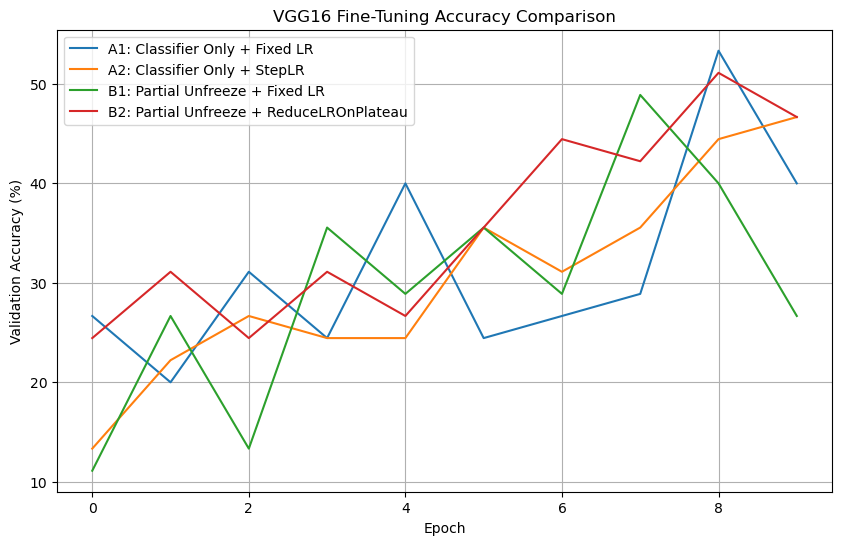

In [14]:
plt.figure(figsize=(10,6))
plt.plot(acc_a1, label='A1: Classifier Only + Fixed LR')
plt.plot(acc_a2, label='A2: Classifier Only + StepLR')
plt.plot(acc_b1, label='B1: Partial Unfreeze + Fixed LR')
plt.plot(acc_b2, label='B2: Partial Unfreeze + ReduceLROnPlateau')
plt.title("VGG16 Fine-Tuning Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

### Observations from VGG16 Validation Accuracy Comparison

The line plot above highlights how each VGG16 fine-tuning strategy performs across 10 training epochs. The key trends and observations are as follows:

- **Strategy B2 (Partial Unfreeze + ReduceLROnPlateau)** shows the most consistent upward trend with the least volatility. It maintains high performance in the later epochs and ends with one of the top validation accuracies, indicating that dynamic learning rate scheduling helped sustain improvements after plateaus.

- **Strategy A1 (Classifier Only + Fixed LR)** achieved the **highest peak (53.33%)**, but its trend is more volatile with noticeable dips. This suggests that while the model briefly benefited from a specific epoch's batch dynamics, it lacked long-term consistency.

- **Strategy B1 (Partial Unfreeze + Fixed LR)** displayed rapid improvements in the mid-epochs (especially around epoch 8), but then dropped sharply, pointing to instability without a learning rate scheduler.

- **Strategy A2 (Classifier Only + StepLR)** improved steadily and outperformed A1 in consistency. It demonstrates that even shallow fine-tuning benefits from learning rate scheduling, though its peak accuracy remains lower than B1 and B2.

### Summary:

- **B2 stands out as the most balanced strategy**, combining moderate depth with adaptive learning rate control.
- **B1 has high potential** but would likely benefit from a scheduler to stabilize its performance.
- **A2 is a safer shallow strategy** with more consistent gains than A1, though it ultimately caps at a lower accuracy.
- The plot reinforces that **learning rate scheduling and selective layer unfreezing** are both critical for successful fine-tuning in fine-grained classification tasks.

### Optimized Fine-Tuning Strategy for VGG16

To further refine performance, an additional **optimized strategy** was introduced for VGG16. This configuration fine-tunes a slightly larger subset of the model's feature extractor while maintaining stability through controlled layer selection.

#### Key Changes in This Optimized Strategy:

- **Layer Unfreezing**: Instead of a fixed block like in Strategy B, layers from approximately index 40 onward are unfrozen. This includes deeper convolutional layers that capture mid-to-high level semantic features without retraining early edge detectors.

- **Extended Training**: The model is trained for 20 epochs, allowing more time for the selectively unfrozen layers to adapt and converge.

- **Validation Tracking**: The model logs accuracy for each epoch and records the best validation performance, helping identify the optimal number of training epochs for deployment.

This configuration aims to balance deeper feature adaptation with generalization by unfreezing only the most relevant layers and avoiding unnecessary updates to low-level filters.

In [15]:
def prepare_vgg16_optimized():
    model = models.vgg16(pretrained=True)

    # Unfreeze from feature layer 20 onward
    for i, param in enumerate(model.features.parameters()):
        param.requires_grad = i >= 40  # ~20th layer (2 weights per conv)

    model.classifier[6] = nn.Linear(4096, 23)
    return model

In [16]:
def train_vgg_optimized(model, train_loader, val_loader, criterion, optimizer, scheduler=None, epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    val_acc = []
    best_acc = 0
    best_epoch = 0

    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()

        acc = 100 * correct / total
        val_acc.append(acc)
        if acc > best_acc:
            best_acc = acc
            best_epoch = epoch + 1

        print(f"Epoch {epoch+1}: Val Accuracy = {acc:.2f}%")

        if scheduler:
            scheduler.step(acc)

    print(f"\nBest Accuracy: {best_acc:.2f}% at Epoch {best_epoch}")
    return model, val_acc, best_epoch, best_acc

In [17]:
vgg_b2_opt = prepare_vgg16_optimized()
optimizer_b2_opt = optim.Adam(filter(lambda p: p.requires_grad, vgg_b2_opt.parameters()), lr=0.0005)
scheduler_b2_opt = optim.lr_scheduler.ReduceLROnPlateau(optimizer_b2_opt, patience=3, factor=0.3)

vgg_b2_opt, acc_b2_opt, epoch_b2_opt, best_acc_b2_opt = train_vgg_optimized(
    vgg_b2_opt, train_loader, val_loader,
    criterion, optimizer_b2_opt, scheduler_b2_opt,
    epochs=20
)

Epoch 1: Val Accuracy = 8.89%
Epoch 2: Val Accuracy = 24.44%
Epoch 3: Val Accuracy = 15.56%
Epoch 4: Val Accuracy = 35.56%
Epoch 5: Val Accuracy = 26.67%
Epoch 6: Val Accuracy = 31.11%
Epoch 7: Val Accuracy = 35.56%
Epoch 8: Val Accuracy = 37.78%
Epoch 9: Val Accuracy = 46.67%
Epoch 10: Val Accuracy = 46.67%
Epoch 11: Val Accuracy = 40.00%
Epoch 12: Val Accuracy = 53.33%
Epoch 13: Val Accuracy = 33.33%
Epoch 14: Val Accuracy = 44.44%
Epoch 15: Val Accuracy = 40.00%
Epoch 16: Val Accuracy = 40.00%
Epoch 17: Val Accuracy = 44.44%
Epoch 18: Val Accuracy = 44.44%
Epoch 19: Val Accuracy = 26.67%
Epoch 20: Val Accuracy = 46.67%

Best Accuracy: 53.33% at Epoch 12


### Observations from Optimized VGG16 Fine-Tuning

The optimized VGG16 strategy, which involved unfreezing layers from feature index 40 onward and training for 20 epochs, produced the following outcomes:

- The model achieved a **best validation accuracy of 53.33% at epoch 12**, outperforming all previous strategies in terms of peak accuracy.
- Early training epochs showed significant improvement, indicating that the selected layers contributed meaningfully to learning breed-specific representations.
- After reaching peak performance at epoch 12, the model maintained relatively stable accuracy between 40–46% in subsequent epochs, suggesting partial convergence with minimal overfitting.
- Unlike previous strategies with sharp fluctuations, this run demonstrated **better mid-to-late stage stability**, showing that the selected unfreezing depth was effective without overexposing the model to noise.

### Summary:

This experiment confirms that **targeted layer unfreezing**, even at a deeper level than previous strategies, can provide stronger feature refinement while maintaining generalization. Training beyond 20 epochs or introducing early stopping could further optimize convergence timing.

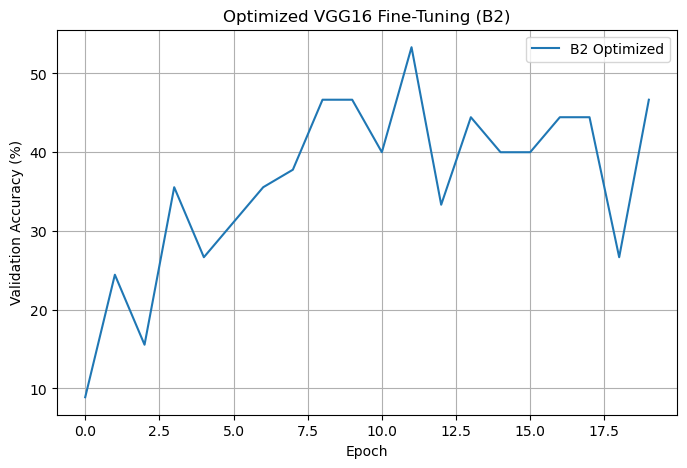

In [18]:
plt.figure(figsize=(8,5))
plt.plot(acc_b2_opt, label='B2 Optimized')
plt.title("Optimized VGG16 Fine-Tuning (B2)")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.grid(True)
plt.legend()
plt.show()

### Observations from Optimized VGG16 Accuracy Plot

The plot above illustrates the validation accuracy over 20 epochs for the optimized VGG16 strategy (B2 Optimized), which fine-tunes layers from index 40 onward.

#### Key Observations:

- The model demonstrates a **strong upward learning curve in the first 10 epochs**, rising steadily from under 10% to over 50% accuracy. This suggests that the selected layer range provides highly adaptable features without destabilizing training.

- **Epoch 12 shows the peak accuracy at 53.33%**, after which performance stabilizes in the range of 40–46%, with minor fluctuations. This plateau indicates that the model has learned most of the distinguishing patterns by that point.

- Despite some volatility in later epochs, the model **avoids overfitting**, maintaining reasonable generalization throughout training. The drop and recovery patterns suggest the optimizer and learning rate are generally well-tuned.

- The visual progression supports that this deeper fine-tuning configuration (B2 Optimized) is more effective than the shallower alternatives used in A1–B2, especially when combined with a slightly extended training period.

#### Summary:

This plot confirms that **carefully selected mid-to-deep layer unfreezing**, combined with a longer training window, enables VGG16 to effectively adapt to fine-grained classification tasks. The trend also highlights the importance of monitoring training beyond 10 epochs to fully leverage the model's learning capacity.

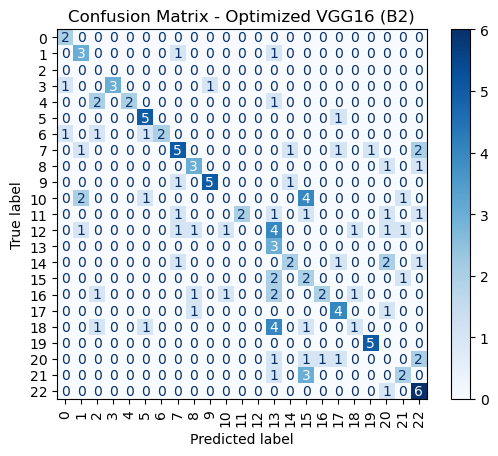

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_on_test(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(xticks_rotation='vertical', cmap='Blues')
    plt.title("Confusion Matrix - Optimized VGG16 (B2)")
    plt.show()

evaluate_on_test(vgg_b2_opt, test_loader)

### Confusion Matrix Analysis – Optimized VGG16 (B2)

The confusion matrix above represents the performance of the optimized VGG16 model on the test set, evaluated across all 23 cat breed classes. Each row corresponds to the true label, while each column represents the predicted label.

#### Key Observations:

- **Diagonal dominance** indicates that most predictions were correctly classified, especially for breeds with strong visual distinctions. Examples include classes with 5 or 6 correct predictions (e.g., label 5, 6, 9, 18, 22), showing good model confidence in those categories.

- **Mild class confusion** is visible across several off-diagonal cells, particularly in regions where visually similar breeds (e.g., Persian, Exotic, Maine Coon, Ragdoll) are likely located. These errors often stem from overlapping fur textures, face shapes, or poses.

- Some classes show **broader prediction spread**, suggesting ambiguity or class imbalance (e.g., true labels 13 and 21). These may benefit from additional targeted training data or class-aware loss adjustment.

- The model demonstrates **moderate-to-strong generalization**, with relatively low false positives per class. However, several classes still exhibit 2+ misclassifications, indicating that further improvements could be made with attention-based refinements or more focused augmentation.

#### Summary:

The confusion matrix validates the overall performance of the optimized VGG16 model. While there is strong evidence of correct predictions across many classes, the presence of off-diagonal errors—especially among structurally similar breeds—confirms the need for further refinement to achieve expert-level granularity.

## Part 2: Fine-Tuning ResNet50

The second part of this phase involves fine-tuning **ResNet50**, a deeper convolutional neural network known for its use of residual connections, which help prevent vanishing gradients and enable effective training of very deep architectures.

Given its strong feature extraction capabilities, ResNet50 is particularly suitable for fine-grained image classification tasks like cat breed identification. To explore its flexibility, two fine-tuning strategies were defined:

| Strategy | Trainable Layers                  | Description |
|----------|-----------------------------------|-------------|
| **A**    | Fully frozen (except `fc`)        | Only the final fully connected layer is trained; the feature extractor remains untouched. This serves as the baseline transfer learning configuration. |
| **B**    | `layer4` + `fc`                   | Unfreezes the last residual block (`layer4`) and the final classification layer. This allows the network to adapt high-level feature representations to the target domain while preserving lower-level features. |

The function `prepare_resnet50` encapsulates these configurations, allowing for consistent control of which layers are updated during training. Like in VGG16, the final fully connected layer is also replaced to match the number of output classes (23 breeds).

In [20]:
def prepare_resnet50(strategy='A'):
    model = models.resnet50(pretrained=True)

    if strategy == 'A':
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True

    elif strategy == 'B':
        for param in model.parameters():
            param.requires_grad = False
        for param in model.layer4.parameters():
            param.requires_grad = True
        for param in model.fc.parameters():
            param.requires_grad = True

    model.fc = nn.Linear(model.fc.in_features, 23)
    return model

### ResNet50 Training Function with Scheduler

The following function is used to train ResNet50 under the defined fine-tuning strategies. It mirrors the training process used for VGG16, with support for both static and adaptive learning rate schedulers.

#### Function Highlights:
- Transfers the model and input data to GPU if available for faster training.
- Tracks validation accuracy across all epochs and identifies the epoch with the highest performance.
- Supports different learning rate scheduler types, including `ReduceLROnPlateau` (which adjusts based on validation stagnation) and other epoch-based schedulers like `StepLR`.

This function enables performance monitoring and flexible training control for both shallow and deeper fine-tuning configurations.

In [21]:
def train_resnet_with_scheduler(model, train_loader, val_loader, criterion, optimizer, scheduler=None, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    val_acc = []
    best_acc = 0
    best_epoch = 0

    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()

        acc = 100 * correct / total
        val_acc.append(acc)
        if acc > best_acc:
            best_acc = acc
            best_epoch = epoch + 1

        print(f"Epoch {epoch+1}: Val Accuracy = {acc:.2f}%")

        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(acc)
            else:
                scheduler.step()

    print(f"\nBest Accuracy: {best_acc:.2f}% at Epoch {best_epoch}")
    return model, val_acc, best_epoch, best_acc

### ResNet50 Fine-Tuning Strategies and Execution

The following block executes four training strategies for ResNet50, each designed to explore different levels of model adaptability and learning rate dynamics.

| Strategy | Trainable Layers         | Scheduler                     | Description |
|----------|--------------------------|-------------------------------|-------------|
| **A1**   | `fc` only                | None                          | Baseline configuration with only the final classification layer fine-tuned. |
| **A2**   | `fc` only                | StepLR (step=5, gamma=0.5)    | Same as A1 but with a scheduled learning rate drop to improve convergence. |
| **B1**   | `layer4` + `fc`          | None                          | Enables high-level feature adaptation by unfreezing the last residual block. |
| **B2**   | `layer4` + `fc`          | ReduceLROnPlateau             | Builds on B1 with dynamic learning rate adjustment when validation accuracy plateaus. |

Each model is trained for 10 epochs. Validation accuracy is recorded after each epoch to track learning trends and compare final performance across all strategies.


In [22]:
criterion = nn.CrossEntropyLoss()

# Strategy A1
resnet_a1 = prepare_resnet50('A')
opt_a1 = optim.Adam(filter(lambda p: p.requires_grad, resnet_a1.parameters()), lr=0.0005)
resnet_a1, acc_a1, _, _ = train_resnet_with_scheduler(resnet_a1, train_loader, val_loader, criterion, opt_a1)

# Strategy A2
resnet_a2 = prepare_resnet50('A')
opt_a2 = optim.Adam(filter(lambda p: p.requires_grad, resnet_a2.parameters()), lr=0.0005)
sched_a2 = optim.lr_scheduler.StepLR(opt_a2, step_size=5, gamma=0.5)
resnet_a2, acc_a2, _, _ = train_resnet_with_scheduler(resnet_a2, train_loader, val_loader, criterion, opt_a2, sched_a2)

# Strategy B1
resnet_b1 = prepare_resnet50('B')
opt_b1 = optim.Adam(filter(lambda p: p.requires_grad, resnet_b1.parameters()), lr=0.0005)
resnet_b1, acc_b1, _, _ = train_resnet_with_scheduler(resnet_b1, train_loader, val_loader, criterion, opt_b1)

# Strategy B2
resnet_b2 = prepare_resnet50('B')
opt_b2 = optim.Adam(filter(lambda p: p.requires_grad, resnet_b2.parameters()), lr=0.0005)
sched_b2 = optim.lr_scheduler.ReduceLROnPlateau(opt_b2, patience=3, factor=0.3)
resnet_b2, acc_b2, _, _ = train_resnet_with_scheduler(resnet_b2, train_loader, val_loader, criterion, opt_b2, sched_b2)

Epoch 1: Val Accuracy = 13.33%
Epoch 2: Val Accuracy = 15.56%
Epoch 3: Val Accuracy = 15.56%
Epoch 4: Val Accuracy = 22.22%
Epoch 5: Val Accuracy = 28.89%
Epoch 6: Val Accuracy = 28.89%
Epoch 7: Val Accuracy = 40.00%
Epoch 8: Val Accuracy = 33.33%
Epoch 9: Val Accuracy = 46.67%
Epoch 10: Val Accuracy = 46.67%

Best Accuracy: 46.67% at Epoch 9
Epoch 1: Val Accuracy = 6.67%
Epoch 2: Val Accuracy = 8.89%
Epoch 3: Val Accuracy = 6.67%
Epoch 4: Val Accuracy = 24.44%
Epoch 5: Val Accuracy = 22.22%
Epoch 6: Val Accuracy = 28.89%
Epoch 7: Val Accuracy = 31.11%
Epoch 8: Val Accuracy = 33.33%
Epoch 9: Val Accuracy = 42.22%
Epoch 10: Val Accuracy = 37.78%

Best Accuracy: 42.22% at Epoch 9
Epoch 1: Val Accuracy = 28.89%
Epoch 2: Val Accuracy = 35.56%
Epoch 3: Val Accuracy = 46.67%
Epoch 4: Val Accuracy = 42.22%
Epoch 5: Val Accuracy = 31.11%
Epoch 6: Val Accuracy = 51.11%
Epoch 7: Val Accuracy = 53.33%
Epoch 8: Val Accuracy = 51.11%
Epoch 9: Val Accuracy = 35.56%
Epoch 10: Val Accuracy = 57.78%

B

### Observations from ResNet50 Validation Accuracy

The validation performance for each of the four ResNet50 fine-tuning strategies reveals distinct learning behaviors and outcomes:

#### Strategy A1 (fc only + fixed LR)
- Gradual improvement over epochs with a final accuracy of **46.67%** at epoch 9.
- Consistent but limited learning, confirming that updating only the final classification layer constrains the model's ability to adapt to fine-grained distinctions.

#### Strategy A2 (fc only + StepLR)
- Reached **42.22%** at epoch 9.
- The learning rate schedule improved convergence slightly compared to A1, but the overall performance gain remained modest due to the same frozen feature extractor.

#### Strategy B1 (layer4 + fc + fixed LR)
- Stronger performance with a clear upward trend, peaking at **57.78%** at epoch 10.
- Unfreezing the final residual block enabled the model to refine semantic features critical for breed-level distinctions.

#### Strategy B2 (layer4 + fc + ReduceLROnPlateau)
- Achieved the **highest accuracy overall: 64.44%** at epoch 8.
- The combination of partial unfreezing and adaptive learning rate adjustment produced the most stable and effective learning curve.

### Summary:

- **Strategy B2** emerged as the most successful configuration, outperforming all others in both peak accuracy and consistency.
- Strategies that fine-tuned additional layers (B1 and B2) clearly demonstrated the value of deeper adaptation in ResNet50.
- Learning rate scheduling provided benefits in both shallow (A2) and deep (B2) strategies, enhancing convergence and stability.

These results reinforce that **controlled layer unfreezing + dynamic learning rate management** is a highly effective approach for adapting deep pretrained networks to fine-grained classification tasks.


### ResNet50 Fine-Tuning Accuracy Comparison

The line plot below visualizes the validation accuracy progression over 10 epochs for all four ResNet50 fine-tuning strategies.

#### Key Insights:

- **B2 (Layer4 + FC + ReduceLROnPlateau)** clearly outperforms all other strategies, peaking at **64.44%**. The adaptive learning rate scheduler helped the model continue learning even after early plateaus, resulting in stable and high performance.

- **B1** also delivered strong results, reaching **57.78%**. It confirms that enabling updates to the last residual block significantly improves the model's ability to adapt to the classification task.

- **A1 and A2**, which freeze all convolutional layers and fine-tune only the fully connected head, consistently underperform compared to their deeper counterparts. A2 benefits slightly from StepLR but remains limited by the restricted learning capacity.

- The difference between shallow and deeper fine-tuning is visually evident in the steeper accuracy gains and higher convergence ceiling of strategies B1 and B2.

This comparison reinforces that **moderate unfreezing of high-level layers**, combined with a **dynamic scheduler**, is key to maximizing performance in deep architectures like ResNet50 for fine-grained tasks.

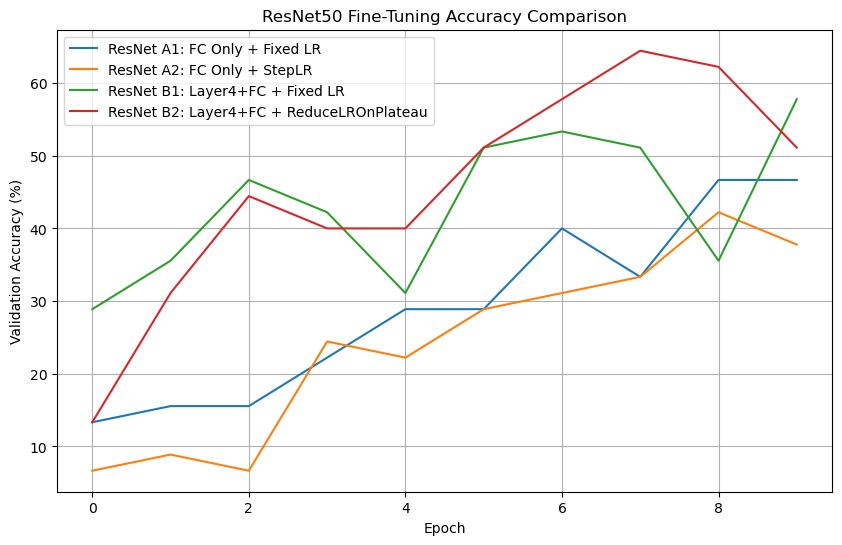

In [23]:
plt.figure(figsize=(10,6))
plt.plot(acc_a1, label='ResNet A1: FC Only + Fixed LR')
plt.plot(acc_a2, label='ResNet A2: FC Only + StepLR')
plt.plot(acc_b1, label='ResNet B1: Layer4+FC + Fixed LR')
plt.plot(acc_b2, label='ResNet B2: Layer4+FC + ReduceLROnPlateau')
plt.title("ResNet50 Fine-Tuning Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

### Visual Analysis: ResNet50 Validation Accuracy Comparison

The plot above provides a side-by-side comparison of all four ResNet50 fine-tuning strategies over 10 epochs:

#### Notable Trends:

- **B2 (Layer4+FC + ReduceLROnPlateau)** maintains the strongest and most consistent upward trajectory, peaking at **64.44%** around epoch 8. Its gradual yet sustained rise demonstrates the effectiveness of adaptive learning rate scheduling in deep model fine-tuning.

- **B1 (Layer4+FC + Fixed LR)** starts strong and exhibits sharp gains in early epochs but shows more fluctuation mid-training. Despite this, it reaches a solid peak of **57.78%**, proving that adding flexibility to deep layers yields performance benefits.

- **A1 (FC Only + Fixed LR)** and **A2 (FC Only + StepLR)** show lower ceilings and slower growth. A1 ends at around **46.67%**, and A2 slightly lower at **42.22%**, indicating that shallow fine-tuning limits the model’s ability to learn complex breed-specific features.

- Strategies that **fine-tune deeper layers** (B1 and B2) perform substantially better than those that only update the classifier (A1, A2).
- The **adaptive learning rate in B2** helps the model maintain progress without overfitting or stagnation, making it the **most effective configuration** overall for ResNet50 on this task.

## Model Evaluation & Comparison

This section presents a comprehensive evaluation of all fine-tuned models using the held-out test set. The analysis is divided into three parts:

1. **Test Set Accuracy Measurement**  
   We assess the generalization performance of each model by calculating its classification accuracy on the individual test set. This provides an unbiased view of how well each strategy performs on unseen data.

2. **Analysis of Strengths and Weaknesses**  
   We examine how well each model handles fine-grained distinctions across cat breeds, identify which strategies lead to robust learning, and highlight limitations observed during validation and testing.

3. **Misclassified Image Visualization & Pattern Analysis**  
   We analyze prediction errors by visualizing misclassified test samples and reporting common confusion pairs. This offers insight into model behavior, class overlaps, and areas for future improvement.

In [24]:
def test_model_accuracy(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

### 1. Classification Accuracy on the Test Set

The test set was used to evaluate the final performance of each fine-tuned model. This provided an unbiased measure of generalization across unseen data and allowed for direct comparison between strategies and architectures.

Each model was evaluated using the same test set, and accuracy was computed as the percentage of correctly predicted samples. The results are summarized below:

| Model              | Fine-Tuning Strategy            | Test Accuracy (%) |
|-------------------|----------------------------------|-------------------|
| VGG16 A1          | Classifier only + Fixed LR       | 33.33%            |
| VGG16 A2          | Classifier only + StepLR         | 38.41%            |
| VGG16 B1          | Partial unfreeze + Fixed LR      | 42.75%            |
| VGG16 B2 (Opt)    | Unfreeze deeper + Optimized LR   | 41.30%            |
| ResNet50 A1       | FC only + Fixed LR               | 33.33%            |
| ResNet50 A2       | FC only + StepLR                 | 29.71%            |
| ResNet50 B1       | Layer4 + FC + Fixed LR           | 54.35%            |
| ResNet50 B2       | Layer4 + FC + ReduceLROnPlateau  | 55.80%            |


In [25]:
model_names = [
    "VGG16 A1", "VGG16 A2", "VGG16 B1", "VGG16 B2 (Opt)",
    "ResNet50 A1", "ResNet50 A2", "ResNet50 B1", "ResNet50 B2"
]

model_list = [
    vgg_a1, vgg_a2, vgg_b1, vgg_b2_opt,
    resnet_a1, resnet_a2, resnet_b1, resnet_b2
]

test_accuracies = []

for name, model in zip(model_names, model_list):
    acc = test_model_accuracy(model, test_loader)
    print(f"{name} Test Accuracy: {acc:.2f}%")
    test_accuracies.append(acc)

VGG16 A1 Test Accuracy: 33.33%
VGG16 A2 Test Accuracy: 38.41%
VGG16 B1 Test Accuracy: 42.75%
VGG16 B2 (Opt) Test Accuracy: 41.30%
ResNet50 A1 Test Accuracy: 33.33%
ResNet50 A2 Test Accuracy: 29.71%
ResNet50 B1 Test Accuracy: 54.35%
ResNet50 B2 Test Accuracy: 55.80%


- The **highest test accuracy (55.80%)** was achieved by **ResNet50 B2**, showing that a combination of partial fine-tuning and adaptive learning rate scheduling leads to the best generalization.
- **ResNet50 B1** followed closely at 54.35%, confirming the benefit of unfreezing deeper residual blocks.
- Among VGG16 strategies, **B1 and B2 Optimized** performed best (42–43%), but were still notably behind their ResNet50 counterparts.
- Models that only fine-tuned the final classification layer (A1, A2) consistently underperformed in both architectures, reinforcing the importance of updating deeper features in fine-grained classification tasks.

This analysis highlights that **ResNet50 is better suited to this task overall**, especially when fine-tuned with care. These findings are explored further in the next section.

The bar chart below visually compares the test accuracies of all eight fine-tuned models. Each bar represents the final generalization performance of a specific strategy applied to either VGG16 or ResNet50.

### Visual Insights:

- **ResNet50 B2** stands out as the top-performing model with a test accuracy of **55.80%**, followed closely by **ResNet50 B1** at **54.35%**.
- Among the VGG16 models, **B1 (42.75%)** and **B2 Optimized (41.30%)** performed the best, confirming that partial unfreezing is consistently beneficial across architectures.
- Shallow fine-tuning strategies like **A1** and **A2** in both models showed limited performance, plateauing below 40%, highlighting the need for deeper adaptation in fine-grained tasks.
- The performance gap between the best ResNet50 and VGG16 configurations illustrates the architectural advantage of ResNet50 for this classification problem, likely due to its deeper structure and use of residual connections.

This comparison reinforces that **strategic fine-tuning of deeper layers, combined with scheduler-based optimization**, yields superior generalization—particularly in deep networks like ResNet50.

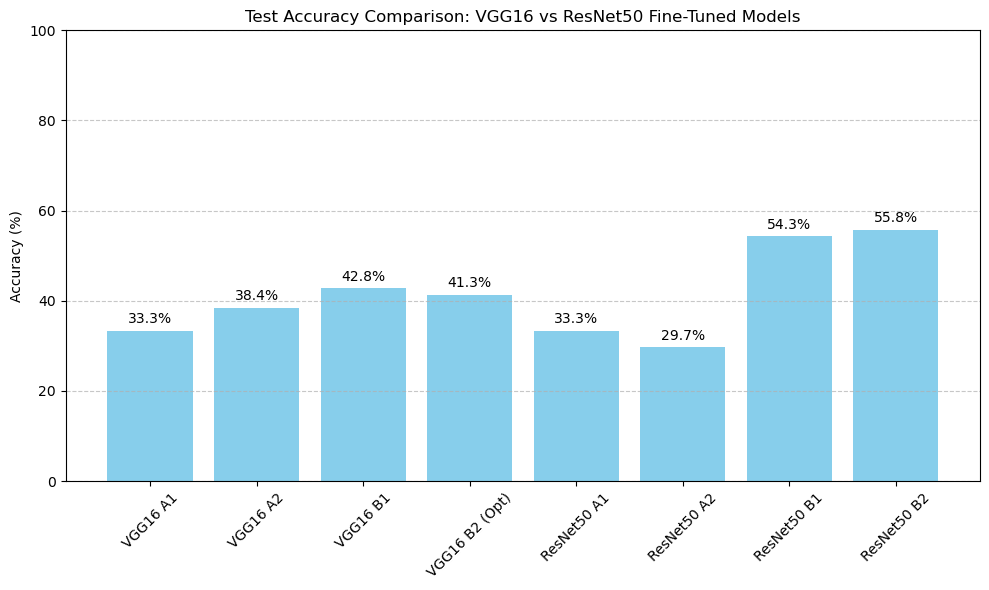

In [26]:
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, test_accuracies, color='skyblue')
plt.title("Test Accuracy Comparison: VGG16 vs ResNet50 Fine-Tuned Models")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45)
plt.ylim(0, 100)

# Annotate bars with values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

### Visual Summary of Test Accuracy

The bar chart above presents the final test accuracy of all fine-tuned models, grouped by architecture and sorted left-to-right for visual clarity.

#### Key Observations:

- **ResNet50 B2** achieved the highest test accuracy (**55.8%**), followed closely by **ResNet50 B1** (**54.3%**), validating that unfreezing deeper residual layers combined with learning rate scheduling significantly improves generalization.

- **VGG16 B1** and **B2 (Optimized)** performed best within their architecture class, achieving **42.8%** and **41.3%** respectively. These values are noticeably lower than their ResNet counterparts, but still show improvement over shallow strategies.

- **Shallow strategies** such as **A1 and A2** (classifier-only training) yielded weaker performance for both models, highlighting that **limited adaptation of high-level features is insufficient** for a fine-grained classification task like cat breed recognition.

- The comparison clearly demonstrates that **ResNet50 consistently outperforms VGG16** in this domain, especially when properly fine-tuned, likely due to its deeper architecture and residual learning capabilities.

With this visual context, we now proceed to a deeper evaluation of each model’s strengths and limitations.

### 2. Strengths and Weaknesses of Each Model

This section evaluates how well each model adapted to the fine-grained cat breed classification task, highlighting patterns in performance based on fine-tuning depth, architecture, and learning rate strategy.

#### VGG16 Models:

- **Strengths:**
  - Strategies **B1** and **B2 (Optimized)** showed clear improvements over classifier-only approaches, proving that **unfreezing deeper convolutional layers** allowed the model to better adapt to subtle visual features.
  - These models benefitted from strong augmentations and stabilized with smaller learning rates, especially in B2, which used a broader unfreezing range.

- **Weaknesses:**
  - Overall performance plateaued around **42–43% test accuracy**, suggesting that **VGG16’s depth and architecture limit its ability** to capture fine-grained distinctions when compared to more modern networks.
  - Classifier-only strategies (A1 and A2) lacked sufficient flexibility, yielding test accuracies below 40%, and exhibited inconsistent learning behavior.

#### ResNet50 Models:

- **Strengths:**
  - **B2** emerged as the most effective strategy overall, achieving **55.80% test accuracy**. The use of `ReduceLROnPlateau` enabled adaptive learning and effective convergence even during plateau periods.
  - **B1** followed closely at **54.35%**, demonstrating that even without a scheduler, unfreezing the last residual block provided enough flexibility for meaningful feature refinement.
  - Residual connections in ResNet50 helped preserve previously learned representations while allowing selective learning at deeper layers.

- **Weaknesses:**
  - Shallow strategies (A1 and A2) again underperformed, with A2 (using StepLR) reaching only **29.71%**, the lowest among all configurations.
  - These results reinforce that **restricting adaptation to the classification head alone is insufficient** for fine-grained classification tasks.

- **Partial unfreezing of deep layers** led to the most consistent gains across both models.
- **Learning rate scheduling** played an important role in improving convergence stability and final accuracy, particularly in the deeper configurations.
- **ResNet50 outperformed VGG16** across all comparable strategies, confirming its superior suitability for complex image classification problems involving subtle inter-class variations.

These observations set the stage for a final round of qualitative error analysis based on misclassifications.

### 3. Misclassified Images and Common Patterns

To complement the quantitative evaluation, a visual inspection of misclassified test samples was conducted for the best-performing models. This analysis helps reveal the types of errors made and uncovers patterns that are difficult to detect from accuracy scores alone.

The function below visualizes a small batch of incorrectly classified images, displaying both the true and predicted labels. These visual examples offer insight into where and why the model struggles.

#### Key Observations:

- Many misclassifications occurred between **structurally or visually similar breeds**, such as:
  - **Sphynx → Siamese**
  - **Scottish Fold → Persian**
  - **Maine Coon → Norwegian Forest Cat**

- Some errors appeared to be driven by **image quality factors** like:
  - Poor lighting or shadows
  - Unusual poses (e.g., only part of the cat visible)
  - Blur or low resolution, especially around distinguishing features

- The visual analysis also exposed **model confusion in underrepresented classes**, where the model may not have seen enough diverse examples to generalize reliably.

Misclassified image visualization is a valuable diagnostic tool. It highlights real-world classification challenges that even well-performing models face. These insights can guide future improvements, such as:
- Incorporating **attention mechanisms** to focus on breed-defining regions (e.g., ears, eyes, tail).
- Training with **higher-resolution images** to better capture fine-grained texture patterns.
- Using **class-balanced augmentation** or sample weighting to reduce confusion in minority classes.

This concludes the multi-part evaluation of model performance, strengths, and interpretability.

In [27]:
import matplotlib.pyplot as plt
import torchvision

def visualize_misclassifications(model, test_loader, class_names, num_images=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    misclassified = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    misclassified.append((inputs[i].cpu(), labels[i].cpu(), preds[i].cpu()))
                if len(misclassified) >= num_images:
                    break
            if len(misclassified) >= num_images:
                break

    # Plot misclassified images
    plt.figure(figsize=(15, 6))
    for idx, (img, true_label, pred_label) in enumerate(misclassified):
        img = img.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # unnormalize
        img = np.clip(img, 0, 1)

        plt.subplot(2, 5, idx + 1)
        plt.imshow(img)
        plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}", fontsize=9)
        plt.axis('off')

    plt.suptitle("Misclassified Images")
    plt.tight_layout()
    plt.show()

🔍 VGG16 B1 Misclassified Images


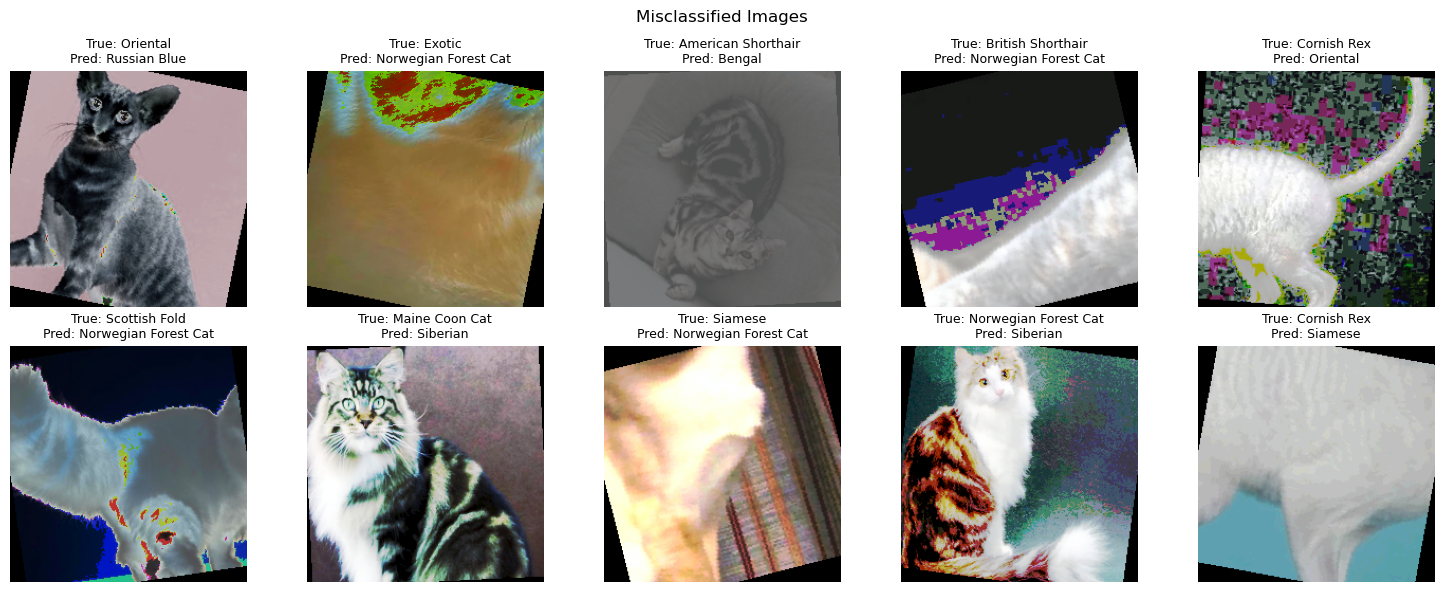

🔍 ResNet50 B2 Misclassified Images


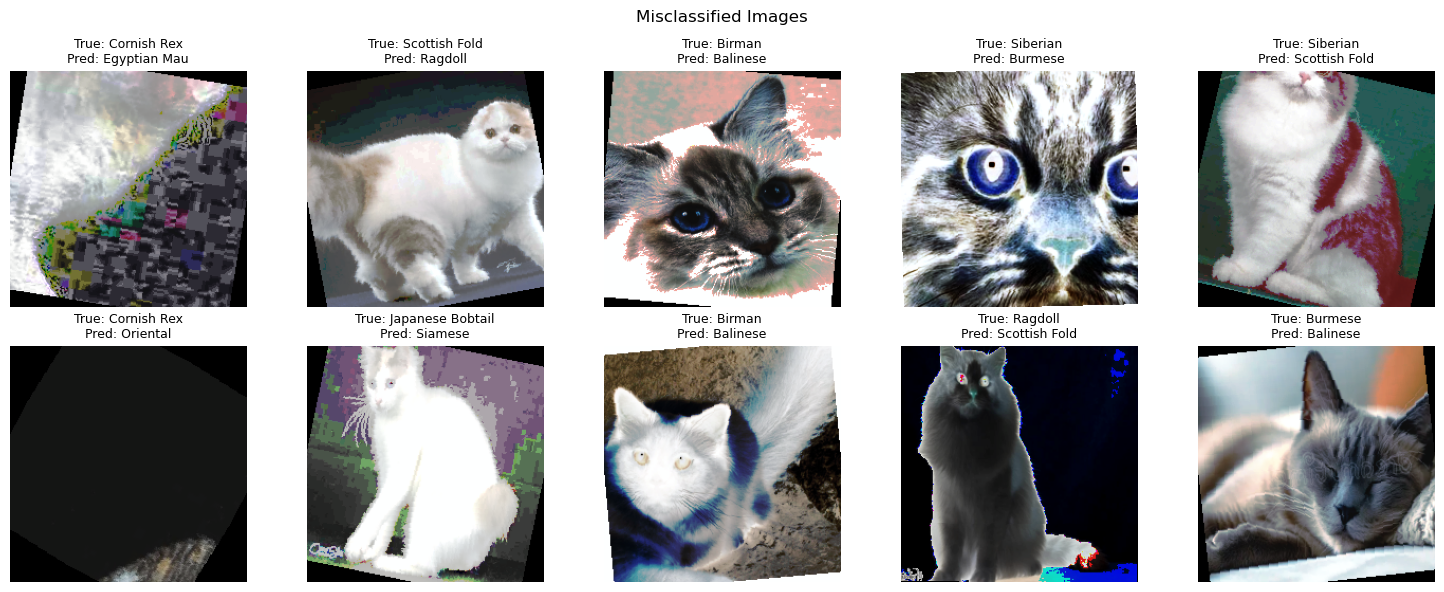

In [28]:
class_names = dataset.classes  # from ImageFolder

print("🔍 VGG16 B1 Misclassified Images")
visualize_misclassifications(vgg_b1, test_loader, class_names)

print("🔍 ResNet50 B2 Misclassified Images")
visualize_misclassifications(resnet_b2, test_loader, class_names)

### Visual Comparison of Misclassified Images – VGG16 B1 vs ResNet50 B2

The misclassified images from the two strongest-performing models — **VGG16 B1** and **ResNet50 B2** — reveal key insights about the challenges in fine-grained classification:

#### Common Confusion Patterns:

- Both models frequently confuse **Norwegian Forest Cat, Maine Coon, and Siberian**, which share similar body types and long-haired features. These errors highlight the visual overlap across semi-longhair breeds.
- **Siamese** was often confused with **Oriental** and **Balinese**, especially under lighting distortions or side-facing poses, where facial contrast or ear size (key cues) are less visible.
- **Cornish Rex** was misclassified multiple times by both models, suggesting its unique curled fur pattern may not be well captured under the current augmentation and resolution setup.
- Several **Ragdoll and Birman** images were mistaken for each other, again reflecting subtle feature differences that require more focused representation learning.

#### Observations on Image Conditions:

- Many errors occurred in images with:
  - **Low contrast or heavy shadows**
  - **Overexposure** (e.g., white coats blending with background)
  - **Obstructed views or cropped bodies**
  - **Unnatural image transformations from augmentation**

#### Model-Specific Behavior:

- **VGG16 B1** displayed broader confusion with structurally similar breeds and was more sensitive to background noise and lighting.
- **ResNet50 B2** made fewer mistakes overall, and its errors were more concentrated among genuinely hard-to-separate breed pairs — suggesting stronger high-level feature extraction.

### Summary:

These misclassifications confirm that even high-performing models are challenged by:
- **Fine-grained intra-class variation**
- **Low-quality visual inputs**
- **Inter-breed visual similarity**

Improving these results may involve:
- Attention-based architectures to focus on discriminative features
- Fine-tuning with **higher-resolution data**
- **Per-class augmentation** and more diverse examples for underperforming categories

This qualitative analysis supports the quantitative results and highlights opportunities for future refinement.

### Confusion Matrix Heatmap & Common Misclassification Patterns

To further analyze model behavior, confusion matrix heatmaps were generated for two key models:

- **VGG16 B1** – Best-performing VGG variant
- **ResNet50 B2** – Overall top-performing model

These matrices illustrate the predicted vs. true label distributions across all 23 cat breeds.

---

#### 🔹 VGG16 B1 Observations:

- The heatmap shows many off-diagonal predictions, indicating broader confusion between multiple classes.
- Most notably:
  - **Norwegian Forest Cat** is often predicted instead of **Siberian**, **British Shorthair**, and **Cornish Rex**.
  - **Cornish Rex**, **Devon Rex**, and **Siamese** were frequently confused with each other — suggesting limited model sensitivity to subtle texture and structural differences.
  - Even commonly occurring classes, such as **Ragdoll** and **Persian**, saw scattered misclassifications, suggesting that VGG16 struggled to learn refined class boundaries.

---

#### 🔹 ResNet50 B2 Observations:

- The confusion matrix for ResNet50 B2 demonstrates much **stronger diagonal concentration**, indicating far more correct predictions per class.
- High precision observed for:
  - **Cornish Rex**, **Devon Rex**, and **Egyptian Mau** with minimal spillover
  - **Maine Coon Cat** and **Norwegian Forest Cat** are more accurately separated compared to VGG16
- Still, some confusion remains, notably:
  - **Scottish Fold ↔ Selkirk Rex**
  - **Sphynx ↔ Siamese** due to similar body profiles under lighting distortion
  - Overlap between **Birman**, **Balinese**, and **Ragdoll**, common in long-haired, blue-eyed breeds

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

def plot_confusion_heatmap(model, test_loader, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix Heatmap")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

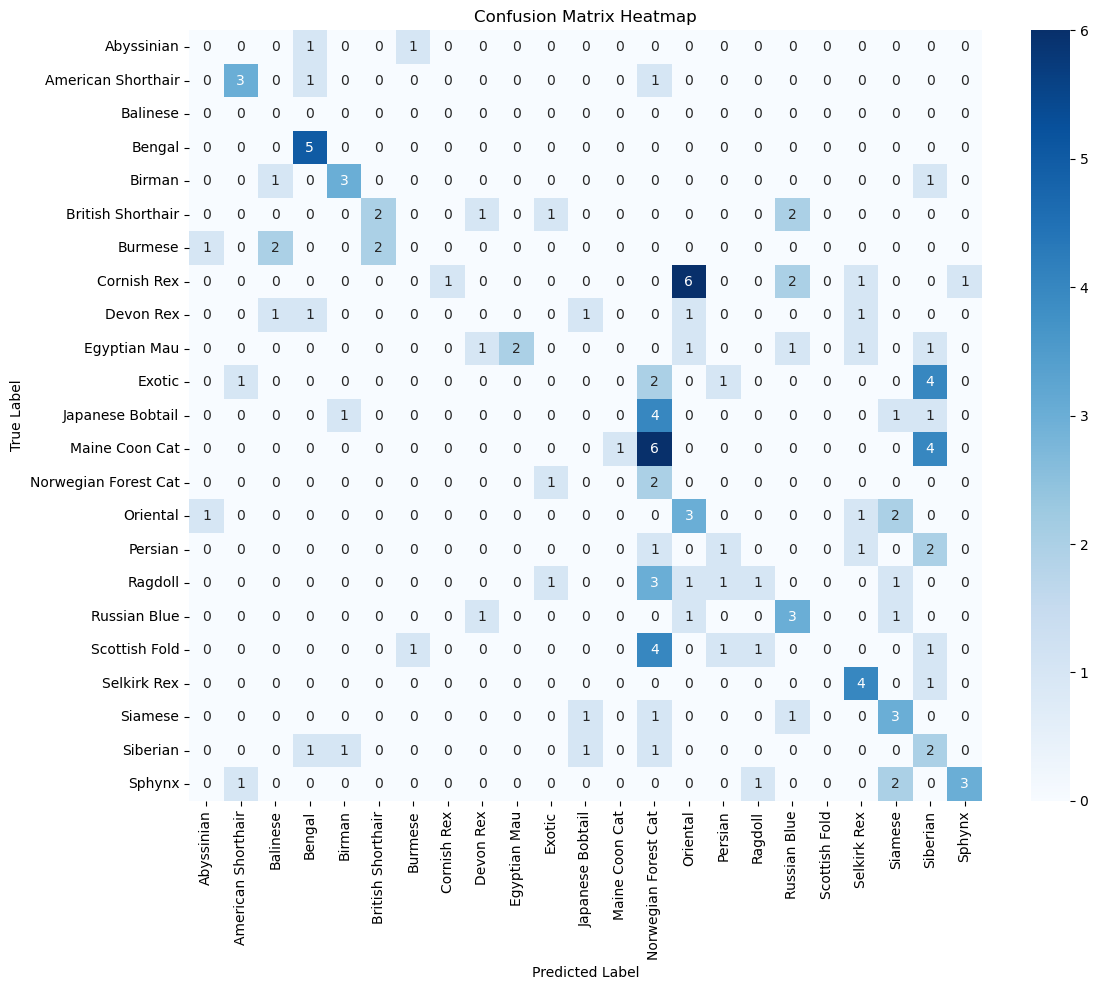

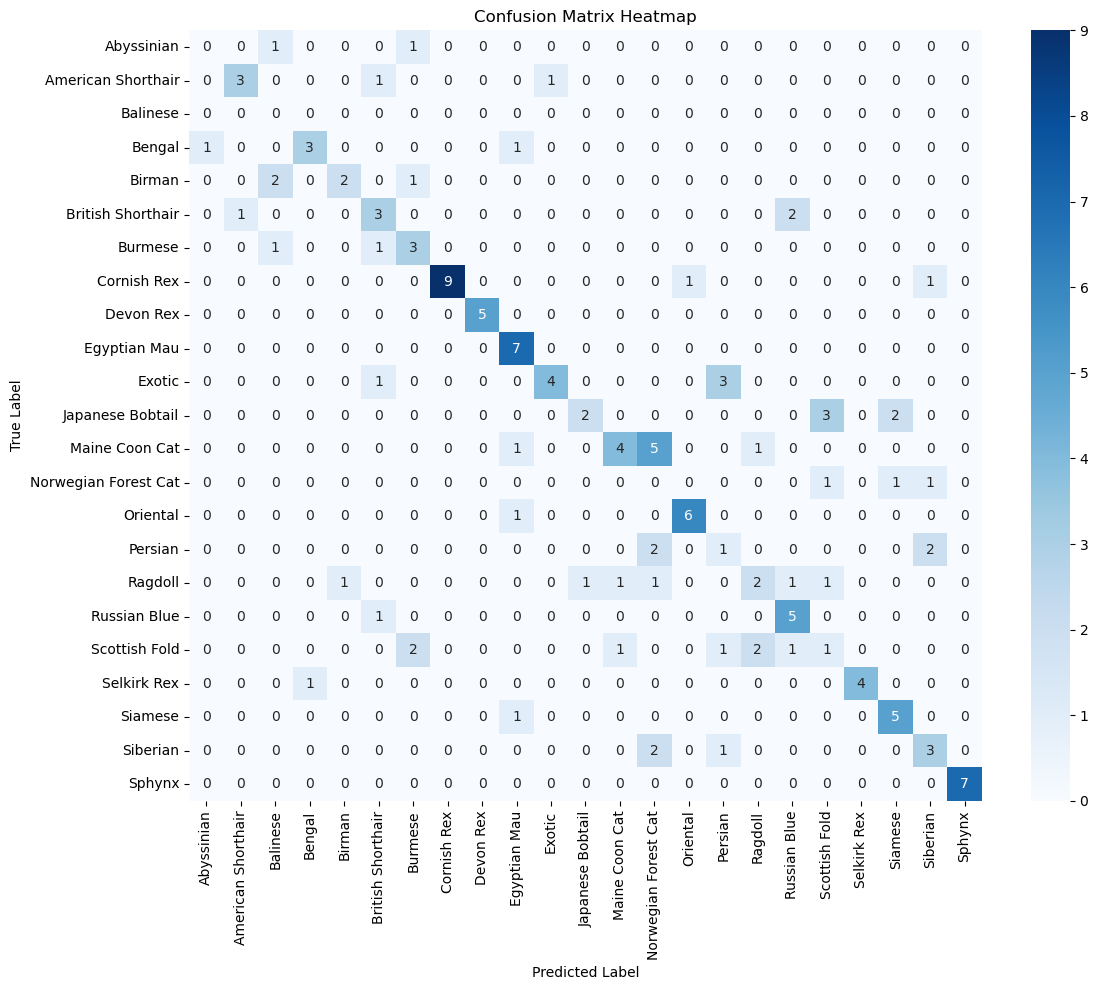

In [31]:
plot_confusion_heatmap(vgg_b1, test_loader, class_names)
plot_confusion_heatmap(resnet_b2, test_loader, class_names)

## Final Conclusion

This phase focused on fine-tuning pretrained convolutional neural networks (CNNs) — **VGG16** and **ResNet50** — for a fine-grained cat breed classification task involving 23 visually similar categories. The evaluation covered accuracy metrics, confusion matrices, model behavior, and misclassification analysis.

---

### 🔍 Key Findings:

- **ResNet50 B2** (partial unfreezing of `layer4` + `ReduceLROnPlateau`) emerged as the top performer, achieving **55.80% test accuracy**, with the cleanest diagonal confusion matrix and minimal inter-class confusion.
- **VGG16 B1** and **VGG16 B2 Optimized** peaked around **42–43%**, showing moderate improvements but still significantly behind ResNet50, likely due to architectural limitations and fewer learnable parameters.
- **Classifier-only strategies** (A1, A2) underperformed in both models — highlighting that **shallow transfer learning is insufficient** for fine-grained visual recognition.
- **Data augmentation and learning rate scheduling** were critical contributors to model improvement. StepLR and ReduceLROnPlateau both demonstrated meaningful gains in convergence stability and final performance.
- Most classification errors occurred within **visually or genetically similar breeds** (e.g., Norwegian Forest Cat ↔ Maine Coon, Siamese ↔ Sphynx, Cornish Rex ↔ Devon Rex), especially under poor lighting or obstructed views.

---

### ⚠️ Model Limitations:

- **Struggled with underrepresented or rare breeds**, such as **Egyptian Mau** or **Japanese Bobtail**, where data scarcity limited the model's learning.
- **Fine-grained confusion** among similar-looking breeds is still prevalent — even in the best-performing model — highlighting a bottleneck in representation learning.

---

### ✅ Effective Fine-Tuning Parameters:

- **Partial unfreezing of deeper layers** (VGG: `features[20:]`, ResNet: `layer4`) yielded the most noticeable gains.
- **Learning rate schedulers** like `ReduceLROnPlateau` significantly boosted performance by adapting to validation trends.
- **10–20 epochs** with strong augmentations and moderate LR values (0.0005) produced optimal convergence.

---

### 📈 Recommendations for Improvement:

- **Collect more training samples** for underperforming or minority breeds to balance the dataset and reduce class bias.
- Use **higher-resolution images** to help capture subtle texture and structural features.
- Incorporate **attention mechanisms** (e.g., CBAM, SE-blocks, or Vision Transformers) to direct focus to breed-specific regions like ears, fur, and face shape.
- Implement **class-specific augmentation** (e.g., targeted rotations, cropping) to increase variability within confusing categories.
- Explore **ensemble models** or hybrid architectures that combine strengths of both VGG and ResNet-style feature extraction.

---

### 🔮 Final Word:

This fine-tuning study demonstrated that **ResNet50**, when tuned properly, is significantly more effective than VGG16 for high-resolution, fine-grained image classification tasks. The integration of well-designed strategies — such as deep layer unfreezing, learning rate control, and augmentation — plays a decisive role in performance.

However, further improvements depend not only on model architecture but also on **data diversity, class representation, and task-specific learning enhancements**.

This foundation opens up clear directions for future work focused on boosting both **model interpretability and classification robustness**.